In [1]:
import numpy as np

class NeuralNetwork:
    def __init__(self, N, hidden_layer_sizes, alpha=0.01, activation="sigmoid", epochs=50, batch_size=128, weight_init="normal", patience=5):
        self.N = N
        self.hidden_layer_sizes = hidden_layer_sizes
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size
        self.activation = activation.lower()
        self.weight_init = weight_init.lower()
        self.patience = patience

        self.weights = None
        self.train_loss = np.full(epochs, np.nan)
        self.valid_loss = np.full(epochs, np.nan)
        self.train_accuracy = np.zeros(epochs)
        self.valid_accuracy = np.zeros(epochs)

    @staticmethod
    def softmax(x):
        x_max = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - x_max)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def activate(self, x):
        activations = {
            "sigmoid": 1 / (1 + np.exp(-np.clip(x, -500, 500))),
            "tanh": np.tanh(x),
            "relu": np.maximum(0, x),
            "leakyrelu": np.where(x > 0, x, 0.01 * x),
        }
        return activations[self.activation]

    def gradient(self, x):
        gradients = {
            "sigmoid": self.activate(x) * (1 - self.activate(x)),
            "tanh": 1 - np.tanh(x) ** 2,
            "relu": np.where(x > 0, 1, 0),
            "leakyrelu": np.where(x > 0, 1, 0.01),
        }
        return gradients[self.activation]

    def loss(self, x, y):
        y_pred_proba = self.predict_proba(x, intercept=False)
        y_pred_proba = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)
        return -np.mean(np.sum(y * np.log(y_pred_proba), axis=1))

    def _initialize_weights(self):
        layers = [self.x_train.shape[1]] + list(self.hidden_layer_sizes) + [self.classes]
        self.weights = []
        
        for i in range(len(layers) - 1):
            if self.activation in ['relu', 'leakyrelu']:
                scale = np.sqrt(2.0 / layers[i])
            else:
                scale = np.sqrt(2.0 / (layers[i] + layers[i + 1]))
                
            if self.weight_init == "zero":
                self.weights.append(np.zeros((layers[i + 1], layers[i])))
            elif self.weight_init == "random":
                self.weights.append(np.random.uniform(-scale, scale, (layers[i + 1], layers[i])))
            else:
                self.weights.append(np.random.normal(0, scale, (layers[i + 1], layers[i])))

    def fit(self, x_train, y_train, x_valid, y_valid):
        self.classes = np.unique(y_train).size
        self.x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
        self.y_train = np.eye(self.classes)[y_train]
        self.x_valid = np.hstack((np.ones((x_valid.shape[0], 1)), x_valid))
        self.y_valid = np.eye(self.classes)[y_valid]
        self._initialize_weights()

    def forward_propagate(self, x):
        self.z_values = []
        self.activations = [x]
        
        for i in range(self.N - 2):
            z = np.dot(self.activations[-1], self.weights[i].T)
            self.z_values.append(z)
            self.activations.append(self.activate(z))
        
        z = np.dot(self.activations[-1], self.weights[-1].T)
        self.z_values.append(z)
        self.activations.append(self.softmax(z))

    def backward_propagate(self, y):
        m = y.shape[0]
        self.deltas = []
        
        delta = self.activations[-1] - y
        self.deltas.append(delta)
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(self.deltas[-1], self.weights[i]) * self.gradient(self.z_values[i - 1])
            self.deltas.append(delta)
            
        self.deltas.reverse()

    def update_weights(self):
        m = self.activations[0].shape[0]
        for i in range(len(self.weights)):
            gradient = np.dot(self.deltas[i].T, self.activations[i]) / m
            self.weights[i] -= self.alpha * gradient

    def propagate(self, x, y):
        self.forward_propagate(x)
        self.backward_propagate(y)
        self.update_weights()

    def train(self):
        
        best_val_loss = float('inf')
        patience_counter = 0
        train_losses = []
        valid_losses = []
        
        for epoch in range(self.epochs):
            indices = np.random.permutation(len(self.x_train))
            x_train_shuffled = self.x_train[indices]
            y_train_shuffled = self.y_train[indices]
            
            for i in range(0, len(self.x_train), self.batch_size):
                x_batch = x_train_shuffled[i:i + self.batch_size]
                y_batch = y_train_shuffled[i:i + self.batch_size]
                self.propagate(x_batch, y_batch)
            
            train_loss = self.loss(self.x_train, self.y_train)
            valid_loss = self.loss(self.x_valid, self.y_valid)
            
            self.train_loss[epoch] = train_loss
            self.valid_loss[epoch] = valid_loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            
            print(f"Epoch {epoch + 1}/{self.epochs}")
            print(f"Train Loss: {train_loss}, Valid Loss: {valid_loss}")
            print("-" * 50)
            
            # early stopping 
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        return np.array(train_losses), np.array(valid_losses)

    def predict(self, x, intercept=True):
        return np.argmax(self.predict_proba(x, intercept), axis=1)

    def predict_proba(self, x, intercept=True):
        x = np.hstack((np.ones((x.shape[0], 1)), x)) if intercept else x
        self.forward_propagate(x)
        return self.activations[-1]

    def score(self, x, y, intercept=True):
        return np.mean(self.predict(x, intercept) == y)


In [ ]:
import numpy as np
import struct
import os
import pickle

def load_idx(filename):
    with open(filename, 'rb') as file:
        m, num_items = struct.unpack(">II", file.read(8))
        if m == 2049:  # Label file
            return np.fromfile(file, dtype=np.uint8)
        elif m == 2051:  # Image file
            num_rows, num_cols = struct.unpack(">II", file.read(8))
            return np.fromfile(file, dtype=np.uint8).reshape(num_items, num_rows * num_cols) / 255.0

train_images = load_idx("dataset/train-images.idx3-ubyte")
train_labels = load_idx("dataset/train-labels.idx1-ubyte") 
test_images = load_idx("dataset/t10k-images.idx3-ubyte")
test_labels = load_idx("dataset/t10k-labels.idx1-ubyte")

total_train_size = len(train_images)
train_size = int(0.8 * total_train_size)
valid_size = int(0.1 * total_train_size)

# split
x_train, y_train = train_images[:train_size], train_labels[:train_size]
x_valid, y_valid = train_images[train_size:train_size + valid_size], train_labels[train_size:train_size + valid_size]

x_test, y_test = test_images[:valid_size], test_labels[:valid_size]

all_results = {}

def train_and_save_model(activation, weight_init, x_train, y_train, x_valid, y_valid, x_test, y_test):
    print(f"\nTraining model with activation={activation}, weight_init={weight_init}")
    print("-" * 80)
    
    # filename
    filename = f"{activation}_{weight_init}.pkl"
    
    # skip if file already exists
    if os.path.exists(filename):
        print(f"Model {filename} already exists, skipping...")
        return
    
    # model
    nn = NeuralNetwork(
        N=6,
        hidden_layer_sizes=[256, 128, 64, 32],
        alpha=2e-3,
        activation=activation,
        epochs=100,
        batch_size=128,
        weight_init=weight_init
    )
    
    nn.fit(x_train, y_train, x_valid, y_valid)
    
    train_losses, valid_losses = nn.train()
    
    # save
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)
    
    print(f"Results for {activation}_{weight_init}:")
    print(f"Results saved to {filename}")
    print("-" * 80)
    
    all_results[f"{activation}_{weight_init}"] = {
        'train_loss': train_losses.tolist(),
        'valid_loss': valid_losses.tolist()
    }


activations = ["sigmoid", "tanh", "relu", "leakyrelu"]
weight_initializations = ["random", "zero", "normal"]

for activation in activations:
    for weight_init in weight_initializations:
        train_and_save_model(activation, weight_init, x_train, y_train, x_valid, y_valid, x_test, y_test)


Training model with activation=sigmoid, weight_init=random
--------------------------------------------------------------------------------
Epoch 1/100
Train Loss: 2.3084849596392045, Valid Loss: 2.3087795622409626
--------------------------------------------------
Epoch 2/100
Train Loss: 2.3033112209710054, Valid Loss: 2.3040410244227285
--------------------------------------------------
Epoch 3/100
Train Loss: 2.3016681801548673, Valid Loss: 2.3026285249371417
--------------------------------------------------
Epoch 4/100
Train Loss: 2.3011682688223436, Valid Loss: 2.3022372132858555
--------------------------------------------------
Epoch 5/100
Train Loss: 2.3010187685160486, Valid Loss: 2.302134535656098
--------------------------------------------------
Epoch 6/100
Train Loss: 2.3009723061086476, Valid Loss: 2.3021260210696615
--------------------------------------------------
Epoch 7/100
Train Loss: 2.3009546739828965, Valid Loss: 2.3021333964124655
-----------------------------

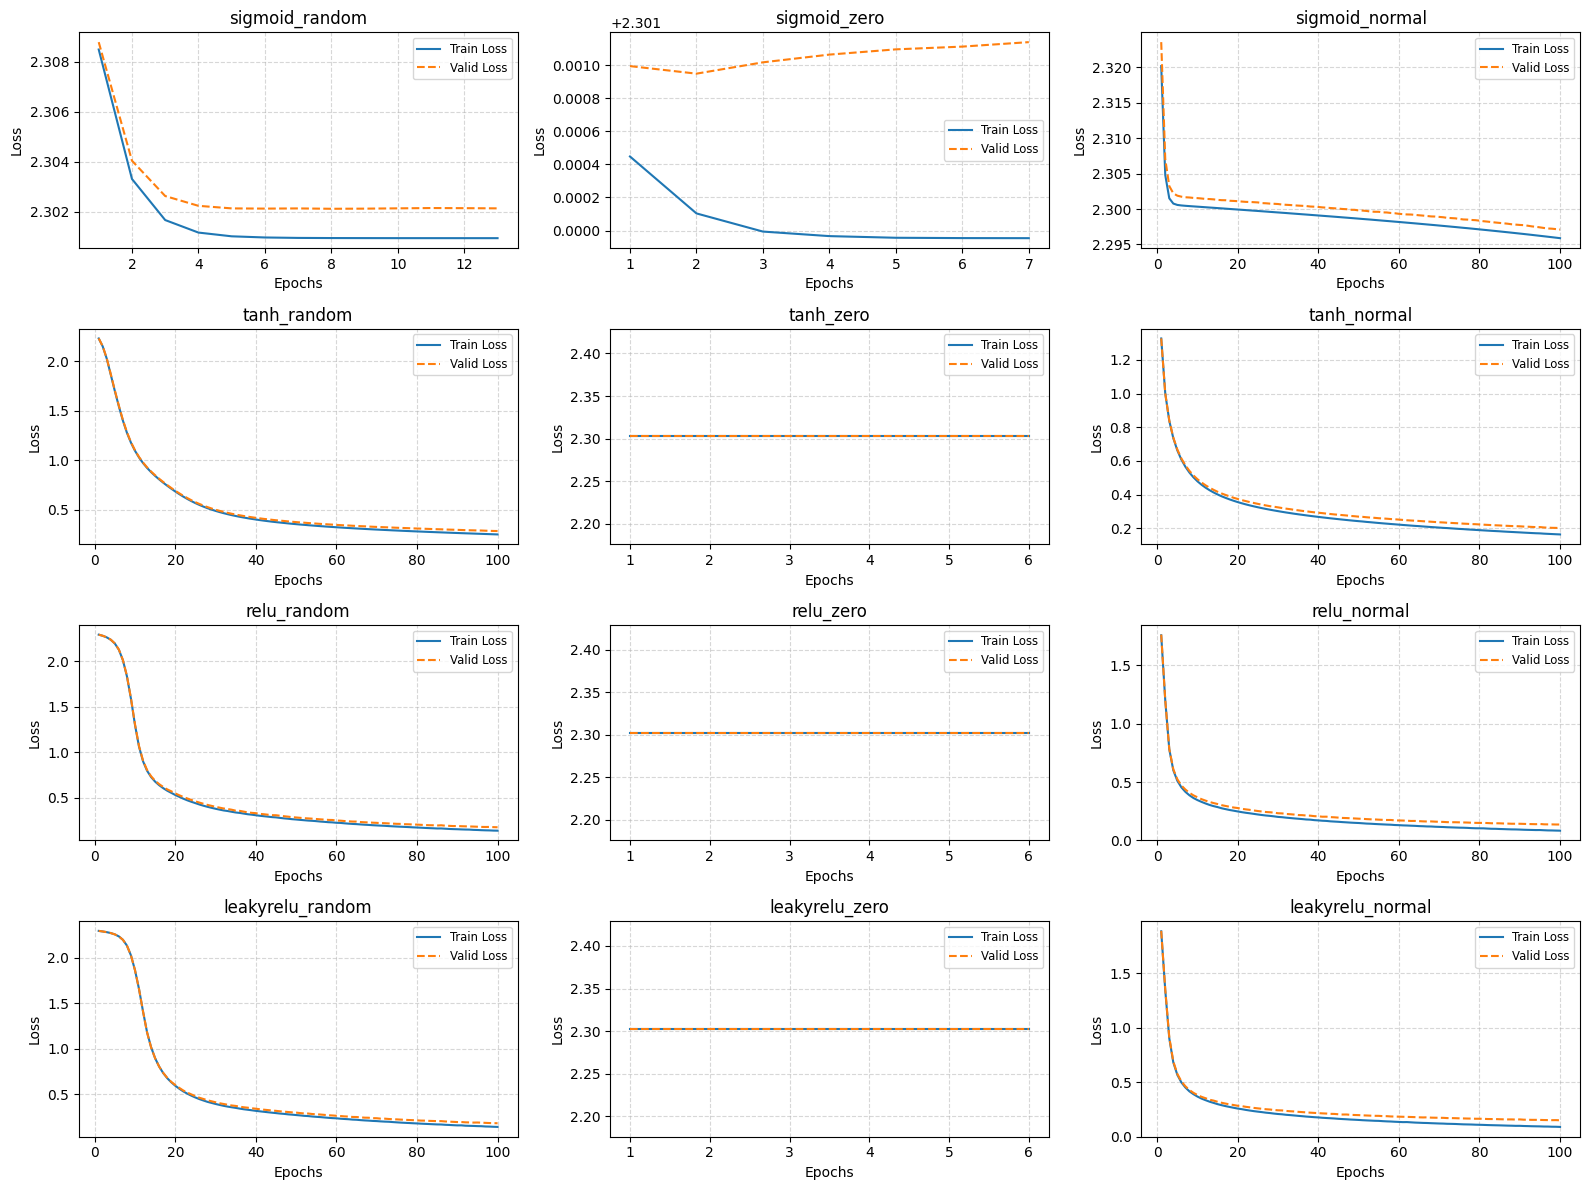

In [3]:
import matplotlib.pyplot as plt

def plot_results(all_results):
    plt.figure(figsize=(16, 12))
    
    for idx, (model_name, losses) in enumerate(all_results.items(), 1):
        train_loss = losses['train_loss']
        valid_loss = losses['valid_loss']
        epochs = range(1, len(train_loss) + 1)

        plt.subplot(4, 3, idx)
        plt.plot(epochs, train_loss, label="Train Loss")
        plt.plot(epochs, valid_loss, label="Valid Loss", linestyle='--')
        
        plt.title(model_name)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(fontsize='small')
        plt.grid(visible=True, linestyle='--', alpha=0.5)
        plt.tight_layout()

    plt.show()

plot_results(all_results)


In [ ]:
import pickle
import numpy as np
import struct
import os
import matplotlib.pyplot as plt

def load_idx(filename):
    with open(filename, 'rb') as file:
        m, num_items = struct.unpack(">II", file.read(8))
        if m == 2049:  # Label file
            return np.fromfile(file, dtype=np.uint8)
        elif m == 2051:  # Image file
            num_rows, num_cols = struct.unpack(">II", file.read(8))
            return np.fromfile(file, dtype=np.uint8).reshape(num_items, num_rows * num_cols) / 255.0

train_images = load_idx("dataset/train-images.idx3-ubyte")
train_labels = load_idx("dataset/train-labels.idx1-ubyte") 
test_images = load_idx("dataset/t10k-images.idx3-ubyte")
test_labels = load_idx("dataset/t10k-labels.idx1-ubyte")

total_train_size = len(train_images)
train_size = int(0.8 * total_train_size)
valid_size = int(0.1 * total_train_size)

x_train, y_train = train_images[:train_size], train_labels[:train_size]
x_valid, y_valid = train_images[train_size:train_size + valid_size], train_labels[train_size:train_size + valid_size]

x_test, y_test = test_images[:valid_size], test_labels[:valid_size]

accuracies = {}
activations = ["sigmoid", "tanh", "relu", "leakyrelu"]
weight_initializations = ["random", "zero", "normal"]

for activation in activations:
    for weight_init in weight_initializations:
        with open(activation + "_" + weight_init + ".pkl", 'rb') as f:
            nn = pickle.load(f)
            test_accuracy = nn.score(x_test, y_test)
            accuracies[(activation, weight_init)] = test_accuracy
            print(f'Activation: {activation}, Init: {weight_init}')
            print(f'Test accuracy: {test_accuracy:.4f}\n')


Activation: sigmoid, Init: random
Test accuracy: 0.1143

Activation: sigmoid, Init: zero
Test accuracy: 0.1143

Activation: sigmoid, Init: normal
Test accuracy: 0.1143

Activation: tanh, Init: random
Test accuracy: 0.9142

Activation: tanh, Init: zero
Test accuracy: 0.0947

Activation: tanh, Init: normal
Test accuracy: 0.9395

Activation: relu, Init: random
Test accuracy: 0.9462

Activation: relu, Init: zero
Test accuracy: 0.0947

Activation: relu, Init: normal
Test accuracy: 0.9577

Activation: leakyrelu, Init: random
Test accuracy: 0.9455

Activation: leakyrelu, Init: zero
Test accuracy: 0.0947

Activation: leakyrelu, Init: normal
Test accuracy: 0.9573



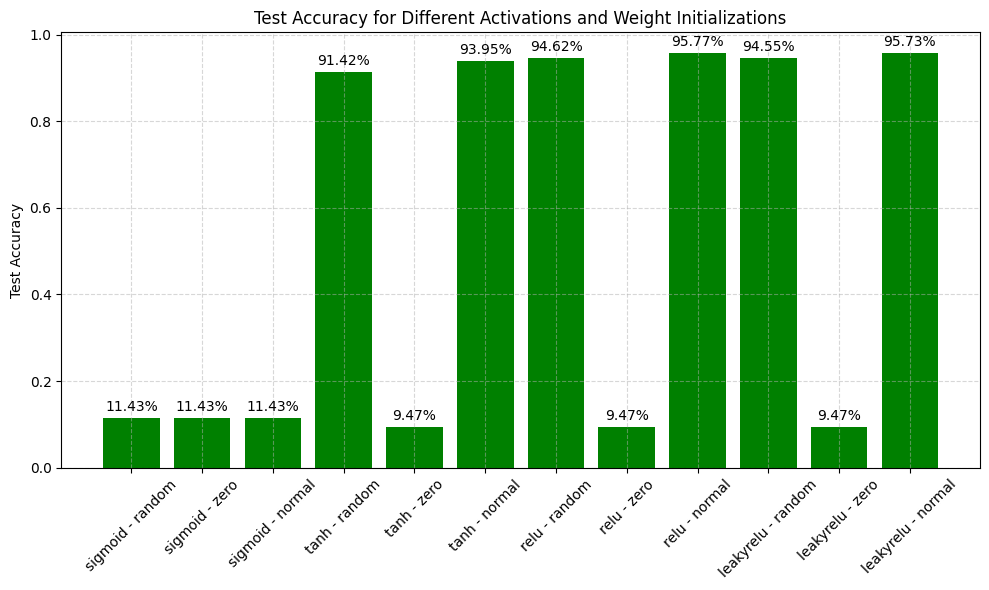

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
activation_labels = [act for act in activations for _ in weight_initializations]
weight_init_labels = weight_initializations * len(activations)
accuracy_values = [accuracies[(act, init)] for act in activations for init in weight_initializations]

bars = ax.bar(range(len(accuracy_values)), accuracy_values, color='green')

for bar, accuracy in zip(bars, accuracy_values):
    height = bar.get_height()
    ax.annotate(f'{accuracy * 100:.2f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  # 3 points vertical offset
                textcoords='offset points', 
                ha='center', va='bottom')

ax.set_xticks(range(len(accuracy_values)))
ax.set_xticklabels([f'{act} - {init}' for act, init in zip(activation_labels, weight_init_labels)], rotation=45)
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy for Different Activations and Weight Initializations')
ax.grid(visible=True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()